# Итоговый проект по дисциплине "Машинное обучение"
## Группа БПМ-22-ПО-1
- Абрамов Иван
- Лысенко Максим
- Нургалиев Родион

# Проект: Алгоритма определения породы собаки

---

### План проекта

Ноутбук разбит на этапы.

* [Шаг 0](#step0): Импорт датасетов
* [Шаг 1](#step1): Детекция людей
* [Шаг 2](#step2): Детекция собак
* [Шаг 3](#step3): Создание CNN для классификации пород (с нуля)
* [Шаг 4](#step4): Создание CNN для классификации пород (с использованием Transfer Learning)
* [Шаг 5](#step5): Написание финального алгоритма
* [Шаг 6](#step6): Тестирование финального алгоритма


---
<a id='step0'></a>

Шаг 0: Импорт датасетов
Скачали датасеты с изображениями людей и собак в формате .zip

Распечатали в формате
`data/dog_images`
`data/lfw`



In [4]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'ML/'
FOLDERNAME = 'ML/dog_breed_classification/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [2]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets,transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader


from PIL import Image,ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from collections import OrderedDict
from tqdm import tqdm
import numpy as np
from glob import glob
import os
import json

import seaborn as sns
import pandas as pd
import numpy as np

import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
!mkdir -p data

!unzip -q /content/drive/MyDrive/ML/dog_breed_classification/dogImages.zip -d data
!mv /content/data/dogImages /content/data/dog_images
!unzip -q /content/drive/MyDrive/ML/dog_breed_classification/lfw.zip -d data

In [6]:
# Следующий код используется для генерации json-файла с catergory_id в качестве ключа и category_name в качестве значения

path = 'data/dog_images/train'
cat_to_name = {}
files = os.listdir(path)
for name in files:
   row = name.split(".")
   cat_to_name[str(int(row[0]))] = row[1]

with open('cat_to_name.json', 'w') as outfile:
   json.dump(cat_to_name, outfile)


In [7]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [8]:
human_files = np.array(glob("data/lfw/*/*"))
dog_files = np.array(glob("data/dog_images/*/*/*"))

print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Шаг 1: Обнаружение людей

В этом разделе мы используем реализацию каскадных классификаторов на основе признаков Хаара в OpenCV для обнаружения человеческих лиц на изображениях.  

OpenCV предоставляет множество предобученных детекторов лиц. Мы загрузили один из таких детекторов и сохранили его в директории `haarcascades`.

Number of faces detected: 1


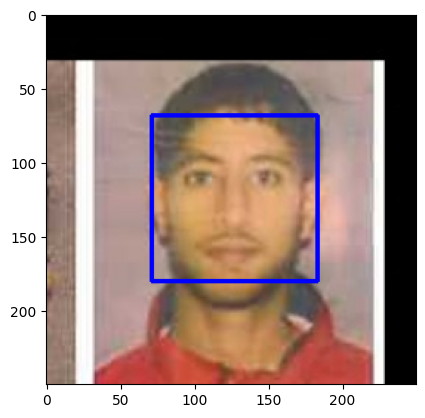

In [10]:
face_cascade = cv2.CascadeClassifier('drive/MyDrive/ML/dog_breed_classification/haarcascades/haarcascade_frontalface_alt.xml')

img = cv2.imread(human_files[0])
# преобразуем изображение BGR в оттенки серого
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# поиск лиц на фото
faces = face_cascade.detectMultiScale(gray)

print('Number of faces detected:', len(faces))

# ограничивающая рамка для каждого обнаруженного лица
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(cv_rgb)
plt.show()

Прежде чем использовать детекторы лиц, мы преобразовали изображение в оттенки серого. Функция `detectMultiScale` применяет классификатор, сохраненный в `face_cascade`, и принимает черно-белое изображение в качестве параметра.  

В нашем коде `faces` — это массив NumPy, содержащий обнаруженные лица, где каждая строка соответствует одному найденному лицу. Каждое обнаруженное лицо представлено одномерным массивом из четырех элементов, задающих ограничивающий прямоугольник (bounding box). Первые два элемента массива (извлеченные в коде как `x` и `y`) определяют горизонтальную и вертикальную координаты верхнего левого угла прямоугольника. Последние два элемента (обозначенные здесь как `w` и `h`) задают ширину и высоту прямоугольника.  

### Создание детектора человеческих лиц  

На основе этого подхода можно написать функцию, которая возвращает `True`, если на изображении обнаружено человеческое лицо, и `False` в противном случае. Эта функция, названная `face_detector`, принимает путь к изображению в виде строки и представлена в следующем блоке кода.

In [11]:
def face_detector(img_path):
    '''
    Args:
        img_path: path to an image

    Returns:
        returns "True" if face is detected in image stored at img_path
    '''
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Оценка работы детектора человеческих лиц


In [12]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

face_detector_v = np.vectorize(face_detector)

human_face = face_detector_v(human_files_short)
dog_human_face = face_detector_v(dog_files_short)

print("Percentage of human faces detected in humans dataset is",human_face.mean()*100,"%")
print("Percentage of human faces detected in dogs dataset is",dog_human_face.mean()*100,"%")

Percentage of human faces detected in humans dataset is 100.0 %
Percentage of human faces detected in dogs dataset is 18.0 %


---
<a id='step2'></a>
## Шаг 2: Обнаружение собак

### Загрузка предобученной модели VGG-16

В ячейке кода ниже загружается модель VGG-16 вместе с весами, обученными на базе данных [ImageNet](http://www.image-net.org/) - наборе данных для классификации изображений.

In [13]:
VGG16 = models.vgg16(pretrained=True)

use_cuda = torch.cuda.is_available()

if use_cuda:
    VGG16 = VGG16.cuda()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 155MB/s]


Для заданного изображения эта предобученная модель VGG-16 возвращает прогноз (выбранный из 1000 возможных категорий ImageNet) объекта, содержащегося на изображении.

### Прогнозирование с использованием предобученной модели


In [14]:
def VGG16_predict(image_path):
    '''
    Args:
        img_path: path to an image

    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    image = Image.open(image_path)

# Определение преобразования для изображения (модели imagenet обучаются с размером изображения 224)
    transformation = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    ])

# Предварительная обработка изображения
    image_tensor = transformation(image).float()

    # Добавляем дополнительное измерение батча, так как PyTorch обрабатывает все изображения как батчи
    image_tensor = image_tensor.unsqueeze_(0)
    image = Variable(image_tensor)
    if use_cuda:
        image = Variable(image_tensor.cuda())

    VGG16.eval()
    # Предсказание класса изображения
    output = VGG16(image)
    output = output.cpu()
    index = output.data.numpy().argmax()

    return int(index)


In [15]:
VGG16_predict(dog_files_short[10])

160

### Создание детектора собак

Категории, соответствующие собакам, расположены непрерывным блоком и охватывают индексы от 151 до 268 включительно - от породы `'Чихуахуа'` до `'Мексиканская голая собака'`. Таким образом, чтобы определить, содержит ли изображение собаку согласно предобученной модели VGG-16, достаточно проверить, попадает ли предсказанный индекс в диапазон от 151 до 268 (включительно).

Функция `dog_detector` возвращает:
- `True` - если на изображении обнаружена собака
- `False` - если собака не обнаружена

In [16]:
def dog_detector(img_path):
    '''
    Use pre-trained VGG-16 model to check if the image
    contains a dog or not

    Args:
        img_path: path to an image

    Returns:
        returns "True" if a dog is detected in the image stored at img_path
    '''
    class_id = VGG16_predict(img_path)
    if(class_id > 150 and class_id < 269):
        return True
    else:
        return False

### Оценка работы детектора собак


In [17]:
dog_detector_v = np.vectorize(dog_detector)

human_detected_dog = dog_detector_v(human_files_short)
dog_detected = dog_detector_v(dog_files_short)

print("Percentage of dogs detected in humans dataset is",human_detected_dog.mean()*100,"%")
print("Percentage of dogs detected in dogs dataset is",dog_detected.mean()*100,"%")

Percentage of dogs detected in humans dataset is 0.0 %
Percentage of dogs detected in dogs dataset is 94.0 %


---
<a id='step3'></a>
## Шаг 3: Создание CNN для классификации пород собак (с нуля)

Задача определения породы собак по изображениям считается сложной в силу обилия пород, даже человеку бывает трудно отличить ту породу от иной.

Случайное угадывание дает крайне низкий результат: даже если не учитывать небольшой дисбаланс классов, случайный выбор даст правильный ответ примерно в 1 случае из 133, что соответствует точности менее 1%.

### Настройка загрузчиков данных для набора изображений собак

Создадим три отдельных загрузчика данных для обучающего, валидационного и тестового наборов изображений собак (расположенных в `dog_images/train`, `dog_images/valid` и `dog_images/test` соответственно).

In [18]:
# количество подпроцессов, используемых для загрузки данных
num_workers = 0
# сколько образцов в партии загружать
batch_size = 20


data_dir = 'data/dog_images'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'


In [19]:
data_transforms = {
    'train' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'valid' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),

    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'test' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),

    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

In [20]:
image_datasets = {
    'train' : ImageFolder(root=train_dir,transform=data_transforms['train']),
    'valid' : ImageFolder(root=valid_dir,transform=data_transforms['valid']),
    'test' : ImageFolder(root=test_dir,transform=data_transforms['test']),
}

In [21]:
data_loaders = {
    'train' : DataLoader(image_datasets['train'],batch_size = batch_size,shuffle=True),
    'valid' : DataLoader(image_datasets['valid'],batch_size = batch_size),
    'test' : DataLoader(image_datasets['test'],batch_size = batch_size)
}

In [22]:
print("Size of training set is: "+str(len(image_datasets['train'])))
print("Size of validation set is: "+str(len(image_datasets['valid'])))
print("Size of testing set is: "+str(len(image_datasets['test'])))

Size of training set is: 6680
Size of validation set is: 835
Size of testing set is: 836


In [23]:
print("Number of classes are: "+str(len(image_datasets['train'].classes)))

Number of classes are: 133


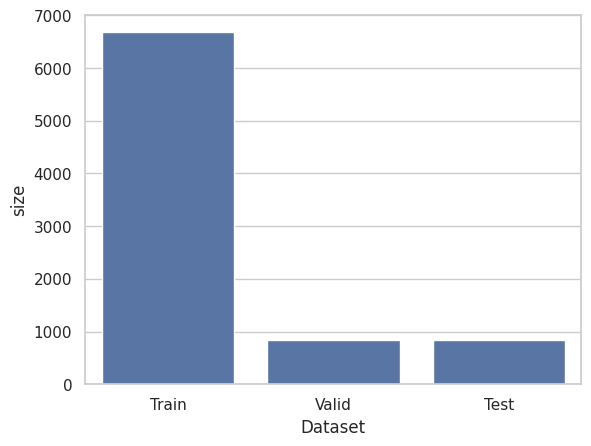

In [24]:
data_size = [['Train',len(image_datasets['train'])],['Valid',len(image_datasets['valid'])],['Test',len(image_datasets['test'])]]
df = pd.DataFrame(data_size,columns=['Dataset','size'])

sns.set(style="whitegrid")
ax = sns.barplot(x="Dataset", y="size", data=df)

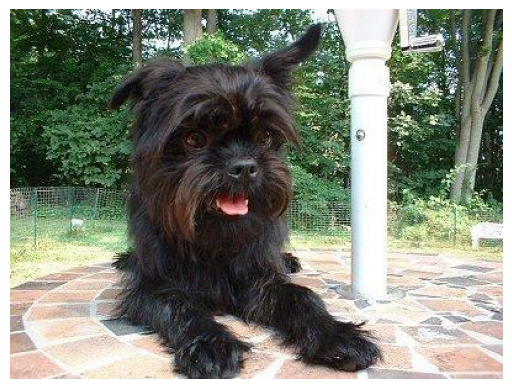

In [25]:
plt.axis('off')
plt.imshow(plt.imread(image_datasets['train'].imgs[0][0]))

In [26]:
path = 'data/dog_images/train'
images = []
titles = []
files = os.listdir(path)
for name in files:
    row = name.split(".")
    all_images = os.listdir(path+'/'+name)
    image = plt.imread(path+'/'+name+'/'+all_images[0])
    images.append(image)
    titles.append(row[1])
    continue


In [27]:

def show_images(images, cols = 1, titles = None):
    """
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.

    cols (Default = 1): Number of columns in figure (number of rows is
                        set to np.ceil(n_images/float(cols))).

    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, int(np.ceil(n_images/float(cols))), n + 1)
        a.set_axis_off()
        plt.axis('off')
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

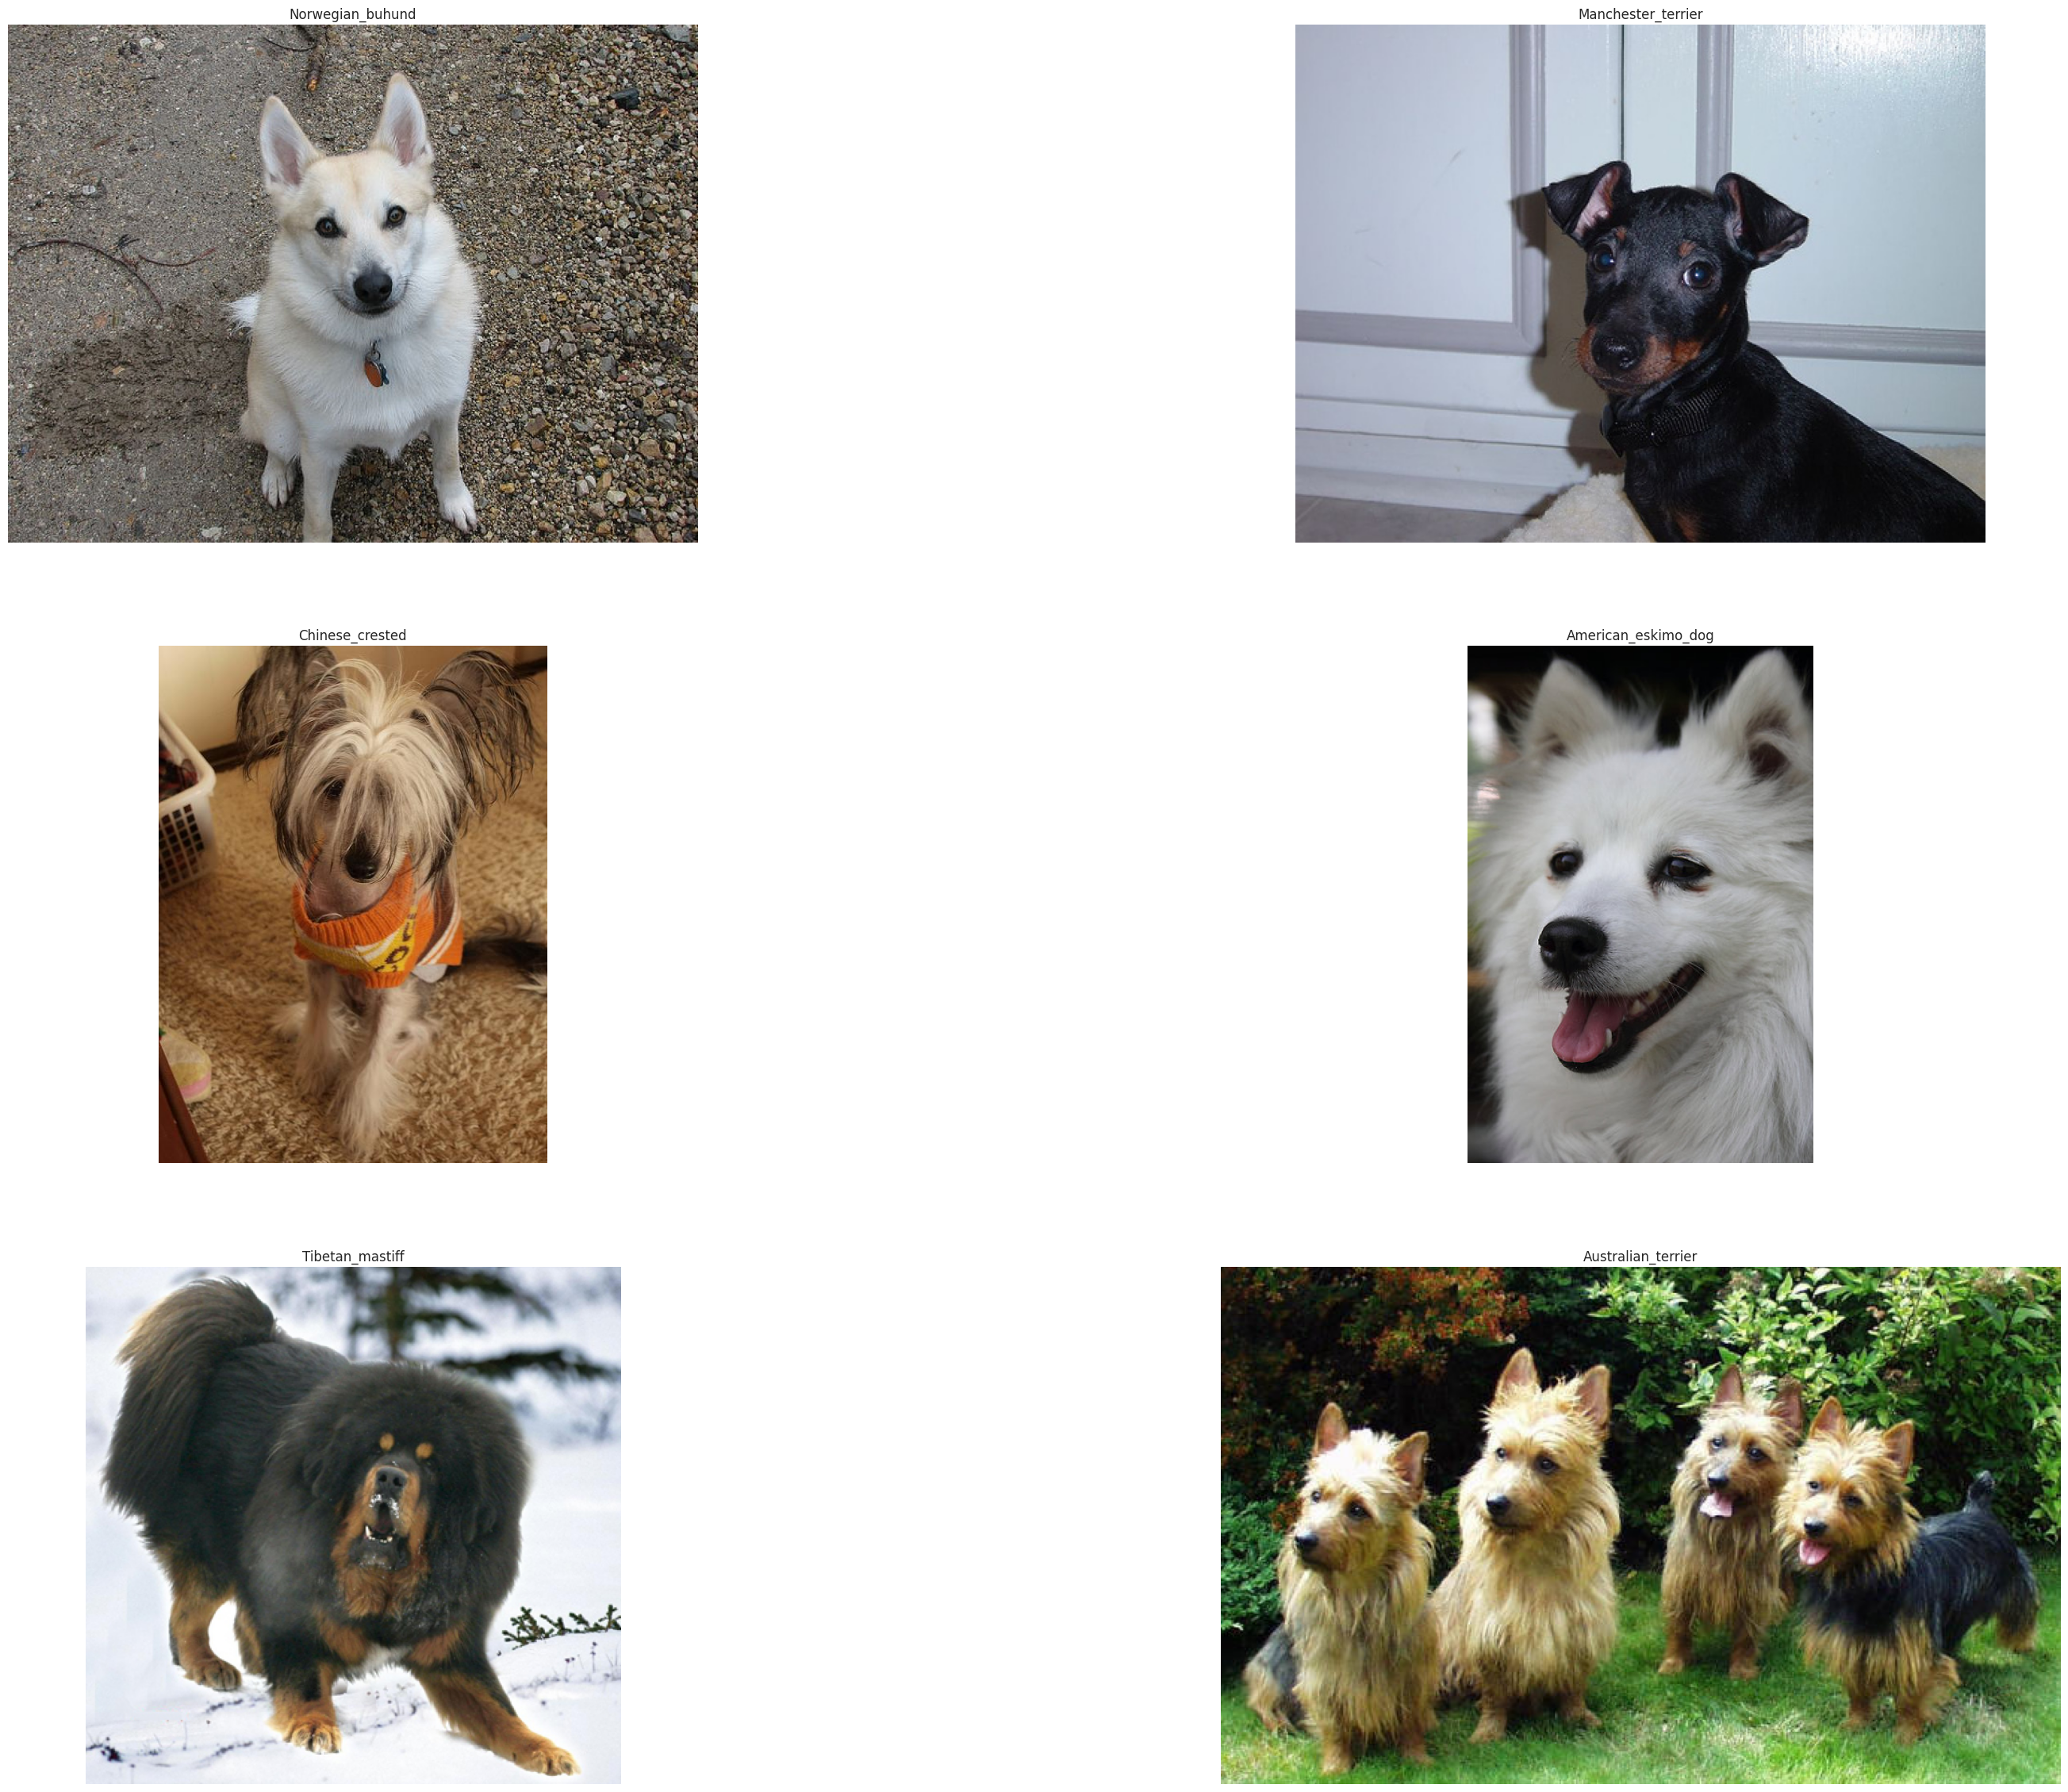

In [28]:
show_images(images[:6], 3, titles[:6])

- Изображения были изменены до размера 224×224 пикселей с сохранением всех цветовых каналов. Размер входного тензора составил 224×224×3.
- Мы применил аугментацию данных к обучающей выборке, включая:
  * Горизонтальное отражение изображений
  * Поворот на 10 градусов

### Архитектура модели

Создайдим сверточную нейронную сеть (CNN) для классификации пород собак.

In [29]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv5 = nn.Conv2d(128, 256, 3)

        self.fc1 = nn.Linear(256 * 6 * 6, 133)

        self.max_pool = nn.MaxPool2d(2, 2,ceil_mode=True)
        self.dropout = nn.Dropout(0.2)

        self.conv_bn1 = nn.BatchNorm2d(224,3)
        self.conv_bn2 = nn.BatchNorm2d(16)
        self.conv_bn3 = nn.BatchNorm2d(32)
        self.conv_bn4 = nn.BatchNorm2d(64)
        self.conv_bn5 = nn.BatchNorm2d(128)
        self.conv_bn6 = nn.BatchNorm2d(256)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = self.conv_bn2(x)

        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = self.conv_bn3(x)

        x = F.relu(self.conv3(x))
        x = self.max_pool(x)
        x = self.conv_bn4(x)

        x = F.relu(self.conv4(x))
        x = self.max_pool(x)
        x = self.conv_bn5(x)

        x = F.relu(self.conv5(x))
        x = self.max_pool(x)
        x = self.conv_bn6(x)

        x = x.view(-1, 256 * 6 * 6)

        x = self.dropout(x)
        x = self.fc1(x)


        return x

# создаем экземпляр CNN
model_scratch = Net()

if use_cuda:
    model_scratch.cuda()

- Мы использовали шесть сверточных слоёв, каждый с ядром 3x3, шагом 1 и без заполнения (padding=0)
- Функция активации ReLU применялась после каждого сверточного слоя, кроме последнего
- Использовались слои макс-пулинга размером 2x2
- Пакетная нормализация (batch normalization) применялась после каждого слоя пулинга
- Добавлен dropout с вероятностью 0.2


### Определение функции потерь и оптимизатора

Сохраним выбранную функцию потерь в переменной `criterion_scratch`, а оптимизатор - в `optimizer_scratch`.

In [30]:
# функция потерь
criterion_scratch = nn.CrossEntropyLoss()

# оптимизатор
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_scratch, step_size=7, gamma=0.1)

## Метрики

- **Точность (Accuracy)**: Точность является одной из ключевых метрик для оценки классификационных моделей. Проще говоря, точность показывает долю правильных предсказаний модели. Поскольку наша задача относится к задачам классификации, измерение точности особенно важно.

- **Функция потерь (Loss)**: Значение функции потерь вычисляется для всех трёх наборов данных (обучающего, валидационного и тестового), чтобы определить, страдает ли модель от переобучения или недообучения.  
  - Если значение потерь на обучающей выборке значительно ниже, чем на валидационной, это указывает на возможное переобучение. Решениями могут быть: уменьшение размера сети или увеличение параметра dropout.  
  - Если:  
    - `потери на обучении` << `потерь на валидации` → переобучение  
    - `потери на обучении` ≈ `потерь на валидации` → недообучение  

### Обучение и валидация модели

Сохраним финальные параметры модели по указанному пути `'model_scratch.pt'`.

In [31]:
def train(n_epochs, loaders, model, optimizer,scheduler, criterion, use_cuda, save_path):
    '''
    Args:
        n_epochs: Number of epochs
        loaders: data loaders
        model: model to be trained
        optimizer: optimizer needed to train the model
        criterion: specify loss function (categorical cross-entropy)
        use_cuda: use GPU if available
        save_path: path to save the model

    Returns:
        returns trained model
    '''
    # инициализируем трекер для минимизации потерь при проверке
    valid_loss_min = np.inf

    for epoch in range(1, n_epochs+1):
        # инициализация переменных для мониторинга потерь при обучении и проверке
        train_loss = 0.0
        valid_loss = 0.0

        # обучение модели
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## найти потерю и обновить параметры модели соответствующим образом
            # очистить градиенты всех оптимизированных переменных
            optimizer.zero_grad()
            # прямой проход: вычисление прогнозируемых выходных данных путем передачи входных данных в модель
            output = model(data)
            # рассчитать потерю партии
            loss = criterion(output, target)
            # обратный проход: вычислить градиент потерь относительно параметров модели
            loss.backward()
            # выполнить один шаг оптимизации (обновление параметров)
            optimizer.step()
            # обновить потерю обучения
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

        # проверить модель
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## обновить среднюю потерю проверки
            # прямой проход: вычислить прогнозируемые выходные данные, передав входные данные в модель
            output = model(data)
            # рассчитать потерю партии
            loss = criterion(output, target)
            # обновить среднюю потерю проверки
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        scheduler.step()


        # рассчитать средние потери
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)


        # вывод статистики обучения/проверки
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
            ))

        ## сохранение модели, если потери при проверке уменьшились
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    return model

In [32]:
# обучение модели
loaders_scratch = data_loaders
n_epochs = 25

model_scratch = train(n_epochs, loaders_scratch, model_scratch, optimizer_scratch,exp_lr_scheduler,
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# загрузить модель, которая показала наилучшую точность проверки
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 0.001072 	Validation Loss: 0.007872
Validation loss decreased (inf --> 0.007872).  Saving model ...
Epoch: 2 	Training Loss: 0.000867 	Validation Loss: 0.006381
Validation loss decreased (0.007872 --> 0.006381).  Saving model ...
Epoch: 3 	Training Loss: 0.000626 	Validation Loss: 0.005177
Validation loss decreased (0.006381 --> 0.005177).  Saving model ...
Epoch: 4 	Training Loss: 0.000473 	Validation Loss: 0.005018
Validation loss decreased (0.005177 --> 0.005018).  Saving model ...
Epoch: 5 	Training Loss: 0.000374 	Validation Loss: 0.004829
Validation loss decreased (0.005018 --> 0.004829).  Saving model ...
Epoch: 6 	Training Loss: 0.000301 	Validation Loss: 0.004906
Epoch: 7 	Training Loss: 0.000239 	Validation Loss: 0.005254
Epoch: 8 	Training Loss: 0.000147 	Validation Loss: 0.004862
Epoch: 9 	Training Loss: 0.000119 	Validation Loss: 0.004850
Epoch: 10 	Training Loss: 0.000105 	Validation Loss: 0.004843
Epoch: 11 	Training Loss: 0.000094 	Validation Lo

<All keys matched successfully>

### Тестирование модели


In [33]:
def test(loaders, model, criterion, use_cuda):
    '''
    Args:
        loaders: data loaders
        model: model to be trained
        criterion: specify loss function (categorical cross-entropy)
        use_cuda: use GPU if available

    Returns:
        print test loss and test accuracy
    '''

    # контроль потери и точности теста
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # прямой проход: вычисление прогнозируемых выходных данных путем передачи входных данных в модель
        output = model(data)
        # подсчитываем потери
        loss = criterion(output, target)
        # обновить средние тестовые потери
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # преобразовать выходные вероятности в предсказанный класс
        pred = output.data.max(1, keepdim=True)[1]
        # сравнить прогнозы с истинным лейблом
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [34]:
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.784055


Test Accuracy: 23% (194/836)


---
<a id='step4'></a>
## Шаг 4: Создание CNN для классификации пород собак (с использованием Transfer Learning)

### Настройка загрузчиков данных для набора изображений собак



In [41]:
loaders_transfer = data_loaders

### Архитектура модели

Применим технику transfer learning для создания сверточной нейронной сети (CNN), классифицирующей породы собак. Сохраним инициализированную модель в переменной `model_transfer`.

In [35]:
model_transfer = models.resnet18(pretrained=True)
print(model_transfer)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 75.3MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
for param in model_transfer.parameters():
    param.requires_grad = False


num_ftrs = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(num_ftrs, 133)

# if GPU is available, move the model to GPU
if use_cuda:
    model_transfer.cuda()

### Определение функции потерь и оптимизатора

В следующей ячейке кода зададим:
- Функцию потерь
- Оптимизатор

Сохраним выбранную функцию потерь в переменной `criterion_transfer`, а оптимизатор - в переменной `optimizer_transfer`.

In [37]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(filter(lambda p: p.requires_grad,model_transfer.parameters()), lr=0.001)

### Обучение и валидация модели

Сохраним итоговые параметры модели по указанному пути `'model_transfer.pt'`.

In [42]:
loaders_transfer = data_loaders
n_epochs = 25
# обучение модели
train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, exp_lr_scheduler,criterion_transfer, use_cuda, 'model_transfer.pt')

# загрузка модели, которая показала наилучший результат
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 0.000118 	Validation Loss: 0.000906
Validation loss decreased (inf --> 0.000906).  Saving model ...
Epoch: 2 	Training Loss: 0.000096 	Validation Loss: 0.000800
Validation loss decreased (0.000906 --> 0.000800).  Saving model ...
Epoch: 3 	Training Loss: 0.000084 	Validation Loss: 0.000813
Epoch: 4 	Training Loss: 0.000074 	Validation Loss: 0.000765
Validation loss decreased (0.000800 --> 0.000765).  Saving model ...
Epoch: 5 	Training Loss: 0.000066 	Validation Loss: 0.000775
Epoch: 6 	Training Loss: 0.000062 	Validation Loss: 0.000755
Validation loss decreased (0.000765 --> 0.000755).  Saving model ...
Epoch: 7 	Training Loss: 0.000057 	Validation Loss: 0.000789
Epoch: 8 	Training Loss: 0.000053 	Validation Loss: 0.000788
Epoch: 9 	Training Loss: 0.000049 	Validation Loss: 0.000773
Epoch: 10 	Training Loss: 0.000048 	Validation Loss: 0.000775
Epoch: 11 	Training Loss: 0.000044 	Validation Loss: 0.000815
Epoch: 12 	Training Loss: 0.000044 	Validation Loss: 0.0

<All keys matched successfully>

### Тестирование модели

Протестируем  модель на тестовом наборе данных изображений собак..

In [43]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.669475


Test Accuracy: 80% (675/836)


### Прогнозирование породы собаки с помощью модели

Напишем функцию, которая принимает путь изображения в качестве входных данных и возвращает породу собаки (`Affenpinscher`, `Afghanhound` и т. д.), предсказанную нашей моделью.

In [44]:
# список имен классов по индексу, т.е. к имени можно получить доступ как class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

def predict_breed_transfer(img_path):
    # загрузка изображения и возврат предсказанной породы
    '''
    Args:
        img_path: path to an image

    Returns:
        Breed name corresponding to model's prediction
    '''
    image = Image.open(img_path)

    # Определим преобразования для изображения, модели imagenet обучаются с размером изображения 224
    transformation = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    ])

    # Предварительная обработка изображения
    image_tensor = transformation(image).float()
    # Добавляем размерность батча, поскольку PyTorch ожидает вход в формате пакета изображений
    image_tensor = image_tensor.unsqueeze_(0)
    image = Variable(image_tensor)
    if use_cuda:
        image = Variable(image_tensor.cuda())

    model_transfer.eval()
    # Предсказание класса изображения
    output = model_transfer(image)
    output = output.cpu()
    index = output.data.numpy().argmax()

    return cat_to_name[str(index)]

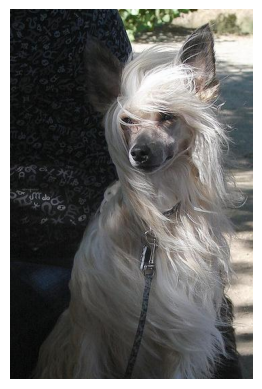

In [45]:
plt.axis('off')
plt.imshow(plt.imread(dog_files_short[10]))

In [46]:
predict_breed_transfer(dog_files_short[10])


'Chihuahua'

---
<a id='step5'></a>
## Шаг 5: Создание алгоритма классификации

Алгоритм принимает путь к изображению и определяет:
1. Содержит ли изображение человека, собаку или ни того ни другого
2. В зависимости от результата:
   - При обнаружении __собаки__ - возвращает предсказанную породу
   - При обнаружении __человека__ - возвращает наиболее похожую породу собаки
   - Если __ничего не обнаружено__ - выводит сообщение об ошибке


### Реализация алгоритма

In [47]:
def run_app(img_path):
    '''
    Args:
        img_path: path to an image

    Returns:
        print if a human face is detected or not
        print the dog breed or show that neither human face nor a dog detected
    '''
    plt.axis('off')
    plt.imshow(plt.imread(img_path))
    is_human = face_detector(img_path)
    is_dog = dog_detector(img_path)
    if(is_human):
        print("Human Face detected")
        print("It looks like the dog "+predict_breed_transfer(img_path))
        return
    elif(is_dog):
        print("It looks like the dog is of breed "+predict_breed_transfer(img_path))
        return
    else:
        print("Neither a human nor a dog")
        return


---
<a id='step6'></a>
## Шаг 6: Тестирование алгоритма

### Тестирование алгоритма на примерах изображений!


Human Face detected
It looks like the dog Dandie_dinmont_terrier


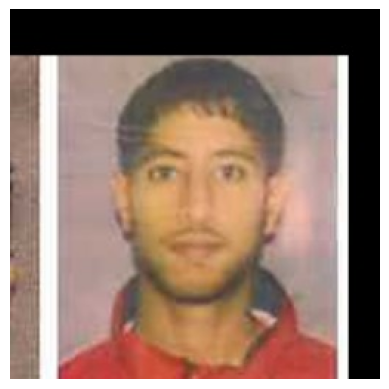

In [48]:
run_app(human_files[0])

It looks like the dog is of breed Norfolk_terrier


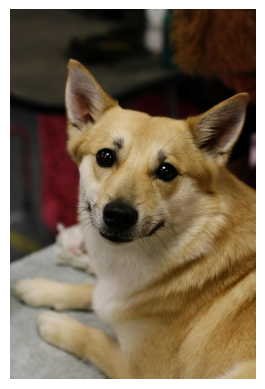

In [53]:
run_app(dog_files[2])

Human Face detected
It looks like the dog Chesapeake_bay_retriever


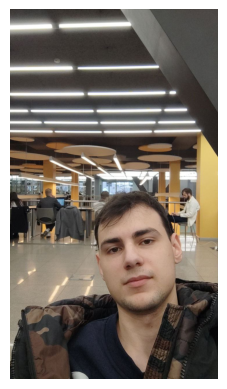

In [55]:
run_app("Maksim.jpg")

It looks like the dog is of breed Dogue_de_bordeaux


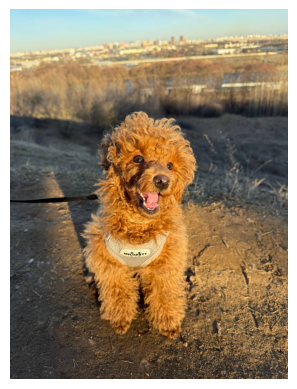

In [61]:
run_app("Bruno.jpg")